In [9]:
import pandas as pd
import os
import json
PARENT_DIR = "../inference/evalute_outputs"

all_outputs = {}

aspects = [ 'actionability', 'grounding_specificity','verifiability', 'helpfulness']

for aspect in aspects:
    all_outputs[aspect] = []

In [10]:
### iterate over folders in the parent directory

for type in ['adapters']:

    path = os.path.join(PARENT_DIR, type)
    for folder in ["Llama-3.1-8B-Instruct",  "SciLitLLM" ]:
        for mode in ['score_only']:
            for temp_type in ['instruction']:
                for step in range(16,145, 16):
                   

                    if folder == "SciLitLLM" and step == 144:
                        step =141


                    model_name = folder

                    ################ MAKE IT MORE CUSTOMIZABLE                
                    automatic_score_only_path = os.path.join(path, folder, f"{mode}/{temp_type}/all/step-{step}/review_evaluation_automatic_labels/results_all_test.txt")

                    human_score_only_path = os.path.join(path, folder, f"{mode}/{temp_type}/all/step-{step}/review_evaluation_human_annotation/results_combined_main_aspects_full.txt")
    
                    # read the json files if they exist
                    automatic_score_only = None
                    human_score_only = None

                    if os.path.exists(automatic_score_only_path):
                        with open(automatic_score_only_path, 'r') as f:
                            automatic_score_only = json.load(f)
                    else:
                        print(f"File missing: {automatic_score_only_path}")

                    if os.path.exists(human_score_only_path):
                        with open(human_score_only_path, 'r') as f:
                            human_score_only = json.load(f)
                    else:
                        print(f"File missing: {human_score_only_path}")

                    # Process the files if they are loaded
                    for aspect in aspects:

                        if automatic_score_only or human_score_only:
                            row = {}
                            row['model_name'] = model_name
                            row['mode'] = mode
                            row['step'] = step
                            row['type'] = type
                            row['tempelate_type'] = temp_type
                            if automatic_score_only:
                                # Extract the relevant data from the automatic score only file
                                auto_results = automatic_score_only['all_test'][aspect]['total_stats']

                                for k,v in auto_results.items():
                                    if k in ['alpha_pairwise', 'tau','original_len','filtered_len','sucess_rate','pearson']: 
                                        continue
                                    row[k] = v
                                
                                for v  in ["num_correct_samples",
                                        "num_uncorrect_samples","rouge_score_correct" ,
                                        "rouge_score_uncorrect",
                                        "bert_score_correct",
                                        "bert_score_uncorrect" 
                                        ]:
                                    if v not in auto_results:
                                        row[v] = "-"


                                # row['QWK_automatic'] = auto_results['kappa_quadratic']
                                # row['pearson_automatic'] = auto_results['pearson']
                                # row['spearman_automatic'] = auto_results['spearman']
                                # row['original_len_automatic'] = auto_results['original_len']
                                # row['processed_len_automatic'] = auto_results['filtered_len']
                                # row['success_rate_automatic'] = auto_results['sucess_rate']
                                # if aspect == 'verifiability':
                                #     row['f1_X'] = auto_results['f1_X']
                                # row['rouge_score'] = auto_results.get('rouge_score', '-')
                                # row['bert_score'] = auto_results.get('bert_score', '-')

                            if human_score_only:
                                # human_results = human_score_only[f'{aspect}_full'][aspect] if model_name != 'chatgpt' else human_score_only[f'combined_main_aspects_full'][aspect]
                                human_results = human_score_only[f'combined_main_aspects_full'][aspect]

                                for annotator in ['Annotator1', 'Annotator2', 'boda', 'total_stats']:
                                    cur_data = human_results[annotator]
                                    row[f'QWK_{annotator}_human'] = cur_data['kappa_quadratic']
                                    # row[f'pearson_{annotator}_human'] = cur_data['pearson']
                                    row[f'spearman_{annotator}_human'] = cur_data['spearman']
                                    if aspect == 'verifiability':
                                        row[f'f1_X_{annotator}_human'] = cur_data['f1_X']

                                    if annotator == 'total_stats':
                                        row[f'alpha_{annotator}_human'] = cur_data['krippendorff_alpha']
                                        # row[f'original_len_human'] = cur_data['original_len']
                                        # row[f'processed_len_human'] = cur_data['filtered_len']
                                        # row['success_rate_human'] = cur_data['sucess_rate']

                            all_outputs[aspect].append(row)

            

# Save the results to an Excel file
with pd.ExcelWriter('results_per_number_of_samples.xlsx') as writer:
    for aspect in aspects:
        df = pd.DataFrame(all_outputs[aspect])
        df.to_excel(writer, sheet_name=aspect, index=False)


File missing: ../inference/evalute_outputs/adapters/SciLitLLM/score_only/instruction/all/step-16/review_evaluation_automatic_labels/results_all_test.txt
File missing: ../inference/evalute_outputs/adapters/SciLitLLM/score_only/instruction/all/step-16/review_evaluation_human_annotation/results_combined_main_aspects_full.txt


In [11]:
results = {}

for aspect in aspects:
    cur_results = all_outputs[aspect]
    cur_results = pd.DataFrame(cur_results)
    
    results[aspect] = {}
    for model_name in ["Llama-3.1-8B-Instruct", "SciLitLLM"]:
        model_results = cur_results[cur_results['model_name'] == model_name]
        steps = model_results['step'].tolist() if 'step' in model_results.columns else []
        
        # Ensure step=16 is included at the beginning for SciLitLLM
        if model_name == "SciLitLLM" and 16 not in steps:
            default_row = pd.DataFrame({
                'model_name': [model_name],
                'step': [16],
                'kappa_quadratic': [0],
                'QWK_total_stats_human': [0]
            })
            model_results = pd.concat([default_row, model_results], ignore_index=True)

        steps = model_results['step'].tolist()
        kappa_quadratic = model_results['kappa_quadratic'].tolist() if 'kappa_quadratic' in model_results.columns else []
        qwk_total_stats = model_results['QWK_total_stats_human'].tolist() if 'QWK_total_stats_human' in model_results.columns else []

        results[aspect][model_name] = {
            'steps': steps,
            'kappa_quadratic': kappa_quadratic,
            'QWK_total_stats_human': qwk_total_stats
        }

    print(f"Results for {aspect}:")
    for model_name in results[aspect]:
        print(f"  {model_name}:")
        print(f"    Steps: {results[aspect][model_name]['steps']}")
        print(f"    Kappa Quadratic: {results[aspect][model_name]['kappa_quadratic']}")
        print(f"    QWK Total Stats Human: {results[aspect][model_name]['QWK_total_stats_human']}")


Results for actionability:
  Llama-3.1-8B-Instruct:
    Steps: [16, 32, 48, 64, 80, 96, 112, 128, 144]
    Kappa Quadratic: [0.166, 0.26, 0.459, 0.603, 0.683, 0.69, 0.694, 0.711, 0.711]
    QWK Total Stats Human: [0.181, 0.17, 0.283, 0.396, 0.471, 0.496, 0.527, 0.506, 0.509]
  SciLitLLM:
    Steps: [16, 32, 48, 64, 80, 96, 112, 128, 141]
    Kappa Quadratic: [0.0, 0.25, 0.351, 0.54, 0.606, 0.642, 0.639, 0.648, 0.651]
    QWK Total Stats Human: [0.0, 0.156, 0.214, 0.315, 0.389, 0.423, 0.454, 0.449, 0.451]
Results for grounding_specificity:
  Llama-3.1-8B-Instruct:
    Steps: [16, 32, 48, 64, 80, 96, 112, 128, 144]
    Kappa Quadratic: [0.204, 0.25, 0.428, 0.578, 0.664, 0.695, 0.678, 0.702, 0.698]
    QWK Total Stats Human: [0.19, 0.14, 0.303, 0.473, 0.499, 0.511, 0.541, 0.522, 0.523]
  SciLitLLM:
    Steps: [16, 32, 48, 64, 80, 96, 112, 128, 141]
    Kappa Quadratic: [0.0, 0.238, 0.401, 0.5, 0.526, 0.544, 0.54, 0.559, 0.559]
    QWK Total Stats Human: [0.0, 0.144, 0.269, 0.388, 0.401, 0

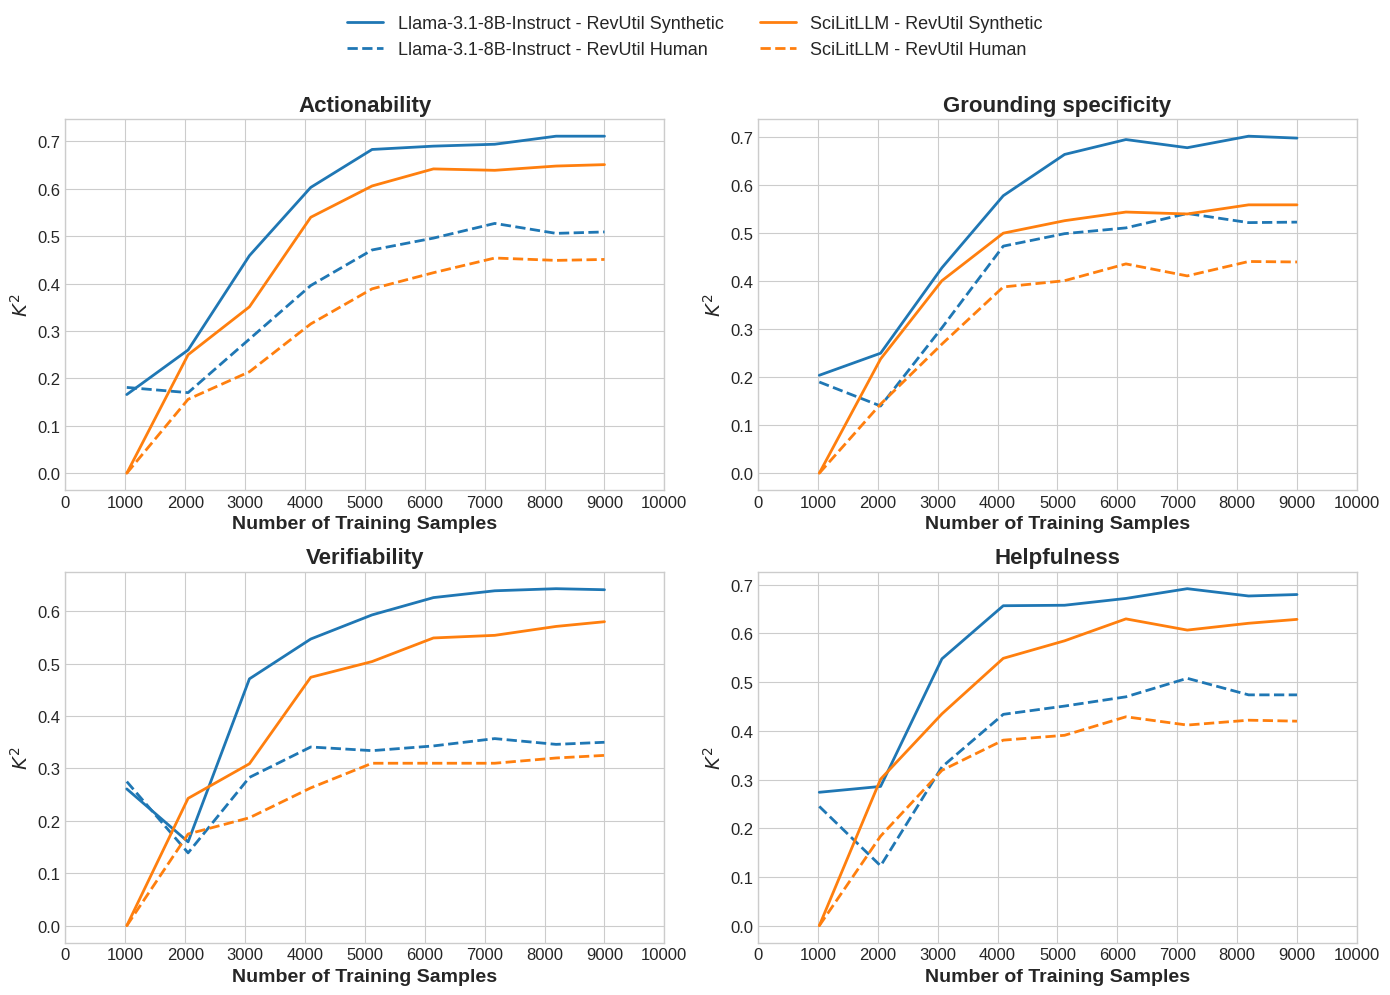

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Optional: Set a consistent style
plt.style.use('seaborn-v0_8-whitegrid')

# Font sizes for better readability
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# Define model colors
model_colors = {
    "Llama-3.1-8B-Instruct": "tab:blue",
    "SciLitLLM": "tab:orange"
}

# Function to convert steps to number of training samples
def steps_to_samples(steps):
    return [(s / 16) * 1024 for s in steps]

# Get the aspects to plot
aspects = list(results.keys())

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()  # Flatten the 2D array for easy iteration

# Plot for each aspect
for i, aspect in enumerate(aspects):
    ax = axs[i]
    
    for model_name in results[aspect]:
        data = results[aspect][model_name]
        steps = data['steps']
        samples = steps_to_samples(steps)

        # Ensure the last value of samples is set to 9000
        if samples:
            samples[-1] = 9000
        kappa = data['kappa_quadratic']
        qwk = data['QWK_total_stats_human']

        color = model_colors.get(model_name, 'black')  # fallback to black if model not in dict

        # Plot kappa quadratic (solid line)
        ax.plot(samples, kappa, label=f'{model_name} - RevUtil Synthetic', color=color, linestyle='-', linewidth=2)
        
        # Plot QWK total stats (dashed line)
        ax.plot(samples, qwk, label=f'{model_name} - RevUtil Human', color=color, linestyle='--', linewidth=2)

    # Set x-axis ticks every 1000 samples
    xticks = np.arange(0, 10001, 1000)
    ax.set_xticks(xticks)

    # Prettify title and labels
    disp_title = ' '.join(aspect.split('_')).capitalize()
    ax.set_title(disp_title, weight='bold')
    ax.set_xlabel('Number of Training Samples', weight='bold')
    ax.set_ylabel('$K^2$', weight='bold')
    ax.grid(True)

# Add a centralized legend above the plots
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False, fontsize=13)

# Tight layout with space at top for legend
plt.tight_layout(rect=[0, 0, 1, 0.92])

# Save and display
plt.savefig('outputs/progression_plot.pdf', format='pdf')
plt.show()
